# Modelos
### XGBoost - Decision Tree - Random Forest - Logistic Regression - LightGBM

Levanta data_df.csv generado por EDA.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

In [2]:
# Lectura del dataset generado en el proceso de EDA.
df = pd.read_csv('data_df.csv')

# df=df.drop(['Unnamed: 0'], axis=1) # Elimino la columna que me generó el pd.write_csv() del EDA.

In [3]:
df.columns

Index(['pol', 'endoso', 'item', 'fecemi', 'tipend', 'idaseg', 'ase_antig_an',
       'ase_cp', 'ase_codnac', 'ase_nac', 'idprod', 'pro_antig_an', 'tipveh',
       'marca', 'modelo', 'anio', 'uso', 'uso_desc', 'cober', 'codcober',
       'cober_desc', 'cob_fecuma', 'cob_ef', 'fraude'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469370 entries, 0 to 469369
Data columns (total 24 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   pol           469370 non-null  int64  
 1   endoso        469370 non-null  int64  
 2   item          469370 non-null  int64  
 3   fecemi        469370 non-null  int64  
 4   tipend        469370 non-null  object 
 5   idaseg        469370 non-null  int64  
 6   ase_antig_an  469370 non-null  int64  
 7   ase_cp        469370 non-null  int64  
 8   ase_codnac    469370 non-null  float64
 9   ase_nac       469370 non-null  object 
 10  idprod        469370 non-null  int64  
 11  pro_antig_an  469370 non-null  int64  
 12  tipveh        469370 non-null  int64  
 13  marca         469370 non-null  int64  
 14  modelo        469370 non-null  int64  
 15  anio          469370 non-null  int64  
 16  uso           469370 non-null  int64  
 17  uso_desc      469370 non-null  object 
 18  cobe

In [5]:
# Feature selection
# df con las variables independientes a incluir en el modelo. Surgen del EDA realizado.
# dfModel =df.drop('fraude', axis=1)
# 
dfModel=df[['endoso', 'ase_antig_an', 'ase_cp', 'ase_codnac', 'idprod', 'pro_antig_an', 
            'marca', 'modelo', 'anio', 'uso', 'codcober', 'cob_ef']]

In [6]:
# Es la variable dependiente/objetivo/target 'fraude'
dfTarget=df['fraude']

In [7]:
# Divido en training y testing. 
X_train, X_test, y_train, y_test = train_test_split(dfModel, dfTarget, test_size = 0.3, random_state=45)

In [8]:
print("Training 0: %.0f" % (y_train.count()))
print("Training 1: %.0f" % (y_train.sum()))
print("            %.4f%%" % (y_train.sum() / y_train.count()))
print("")
print("Testing 0: %.0f" % (y_test.count()))
print("Testing 1: %.0f" % (y_test.sum()))
print("           %.4f%%" % (y_test.sum() / y_test.count()))

Training 0: 328559
Training 1: 12140
            0.0369%

Testing 0: 140811
Testing 1: 5096
           0.0362%


In [9]:
# Divido en training y testing. Utilizo 'stratify' para mantener la proporción de positivos y negativos en train y test.
X_train, X_test, y_train, y_test = train_test_split(dfModel, dfTarget, test_size = 0.3, random_state=45, stratify=dfTarget)

In [10]:
print("Training 0: %.0f" % (y_train.count()))
print("Training 1: %.0f" % (y_train.sum()))
print("            %.4f%%" % (y_train.sum() / y_train.count()))
print("")
print("Testing 0: %.0f" % (y_test.count()))
print("Testing 1: %.0f" % (y_test.sum()))
print("           %.4f%%" % (y_test.sum() / y_test.count()))

Training 0: 328559
Training 1: 12065
            0.0367%

Testing 0: 140811
Testing 1: 5171
           0.0367%


###  ---Algoritmo XGBoost con BO---

In [11]:
# !pip install xgboost
import xgboost as xgb
from xgboost import XGBClassifier ## Categorical target variable
# from xgboost import XGBRegressor ## Continuous target variable

In [13]:
def xgb_classifier(n_estimators, max_depth, reg_alpha, reg_lambda, min_child_weight, num_boost_round, gamma):
    params = {"booster": 'gbtree',
              "objective" : "binary:logistic",
              "eval_metric" : "auc", 
              "is_unbalance": True,
              "n_estimators": int(n_estimators),
              "max_depth" : int(max_depth),
              "reg_alpha" : reg_alpha,
              "reg_lambda" : reg_lambda,
              "gamma": gamma,
              "num_threads" : 20,
              "min_child_weight" : int(min_child_weight),
              "learning_rate" : 0.02,
              "subsample_freq" : 5,
              "seed" : 42,
              "verbosity" : 0,
              "num_boost_round": int(num_boost_round)}
    
    train_data = xgb.DMatrix(X_train, y_train)
    
    cv_result = xgb.cv(params, train_data, 1000, early_stopping_rounds=100, stratified=True, nfold=3)
    return cv_result['test-auc-mean'].iloc[-1]

In [14]:
# !pip install bayesian-optimization
from bayes_opt import BayesianOptimization
xgbBO = BayesianOptimization(xgb_classifier, {  'n_estimators': (10, 100),
                                                'max_depth': (5, 40),
                                                'reg_alpha': (0.0, 0.1),
                                                'reg_lambda': (0.0, 0.1),
                                                'min_child_weight': (1, 10),
                                                'num_boost_round': (100, 1000),
                                                "gamma": (0, 10)
                                                })

In [40]:
xgbBO.maximize(n_iter=20, init_points=2) # n_iter=35

|   iter    |  target   |   gamma   | max_depth | min_ch... | n_esti... | num_bo... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.9352   |  1.215    |  12.78    |  5.764    |  68.1     |  596.4    |  0.0452   |  0.004125 |
|  2        |  0.9375   |  8.141    |  10.38    |  6.78     |  11.32    |  863.2    |  0.08672  |  0.04802  |
|  3        |  0.9369   |  6.743    |  6.679    |  9.934    |  14.89    |  860.9    |  0.01637  |  0.03442  |
|  4        |  0.9371   |  7.404    |  26.44    |  7.705    |  12.58    |  866.9    |  0.06617  |  0.0326   |
|  5        |  0.9371   |  6.218    |  6.244    |  9.886    |  14.22    |  858.5    |  0.02506  |  0.07567  |
|  6        |  0.9368   |  4.793    |  19.1     |  3.073    |  11.08    |  851.4    |  0.02197  |  0.0265   |
|  7        |  0.9369   |  9.563    |  7.478    |  1.847    |  10.77    |  853.2    |  0.0858   |  0.08389  |
|  8      

In [41]:
xgbBO.max

{'target': 0.937502,
 'params': {'gamma': 8.141210926403971,
  'max_depth': 10.375142001632327,
  'min_child_weight': 6.779723064345376,
  'n_estimators': 11.320640191991654,
  'num_boost_round': 863.1863888614448,
  'reg_alpha': 0.08672170218151724,
  'reg_lambda': 0.048019737256687234}}

In [15]:
# clf_xgb=XGBClassifier(use_label_encoder=False, 
#                       colsample_bytree = 0.5, 
#                       learning_rate = 0.2,
#                       gamma =  7.913757545198536,
#                       max_depth = 7,
#                       min_child_weight = 1.9202611553414282,
#                       alpha = 10, 
#                       n_estimators = 45,
#                       reg_alpha =   0.07711402098002348,
#                       reg_lambda = 0.0433274269286166,
#                       eval_metric='auc')

# n_estimators = 45

clf_xgb=XGBClassifier(use_label_encoder=False, 
                      colsample_bytree = 0.5, 
                      learning_rate = 0.2,
                      gamma =  8.141210926403971,
                      max_depth = 10,
                      min_child_weight = 6.779723064345376,
                      alpha = 10, 
                      n_estimators = 50,
                      reg_alpha = 0.08672170218151724,
                      reg_lambda = 0.048019737256687234,
                      eval_metric='auc')

In [16]:
# Fitting model
clf_xgb.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='auc',
              gamma=8.141210926403971, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=10, min_child_weight=6.779723064345376, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, random_state=0,
              reg_alpha=0.08672170218151724, reg_lambda=0.048019737256687234,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

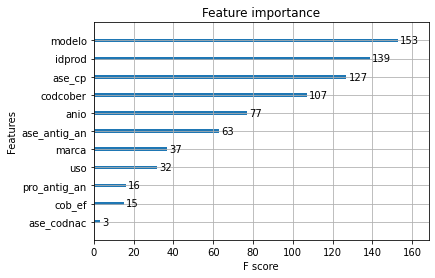

In [17]:
# la variable que mas toma en cuenta el clasificador.
xgb.plot_importance(clf_xgb, ax=plt.gca())
y_pred  = clf_xgb.predict(X_test)

In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    135640
           1       0.56      0.59      0.58      5171

    accuracy                           0.97    140811
   macro avg       0.77      0.79      0.78    140811
weighted avg       0.97      0.97      0.97    140811



In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[133215,   2425],
       [  2098,   3073]], dtype=int64)

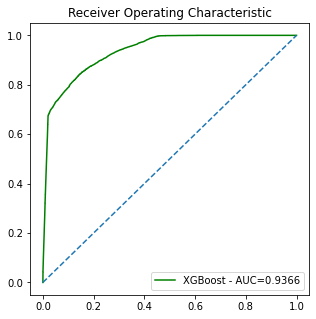

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

y_pred_proba = clf_xgb.predict_proba(X_test)[::,1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test,  y_pred_proba)
auc_xgb = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_xgb,tpr_xgb,color="green",label="XGBoost - AUC=%.4f" % auc_xgb)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.legend(loc=4)
plt.show()

### ---Decision Tree---

In [21]:
# Load libraries
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [22]:
# Create Decision Tree classifer object
clf_dt = DecisionTreeClassifier()
# Train Decision Tree Classifer
clf_dt = clf_dt.fit(X_train,y_train)
#Predict the response for test dataset
y_pred = clf_dt.predict(X_test)

In [23]:
# Visualizing Decision Trees
# !pip install StringIO

# from sklearn.externals.six import StringIO  
# from IPython.display import Image  
# from sklearn.tree import export_graphviz
# import pydotplus
# dot_data = StringIO()
# export_graphviz(clf_dt, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True, feature_names = feature_cols,class_names=['0','1'])
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('decision_tree.png')
# Image(graph.create_png())

In [24]:
# view accuracy
# from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_test)
print('Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

Model accuracy score: 0.9534


In [25]:
y_pred_train = clf_dt.predict(X_train)

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    135640
           1       0.37      0.38      0.38      5171

    accuracy                           0.95    140811
   macro avg       0.67      0.68      0.68    140811
weighted avg       0.95      0.95      0.95    140811



In [27]:
confusion_matrix(y_test, y_pred)

array([[132278,   3362],
       [  3193,   1978]], dtype=int64)

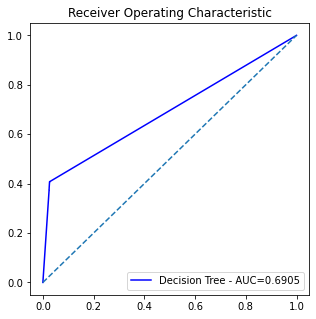

In [28]:
y_pred_proba = clf_dt.predict_proba(X_test)[::,1]
fpr_dt, tpr_dt, _ = roc_curve(y_test,  y_pred_proba)
auc_dt = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_dt,tpr_dt,color="blue",label="Decision Tree - AUC=%.4f" % auc_dt)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.legend(loc=4)
plt.show()

### ---Random Forest---

In [29]:
# Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
# Create a Gaussian Classifier
clf_rf=RandomForestClassifier(n_estimators=100)
# Train the model using the training sets y_pred=clf.predict(X_test)
clf_rf.fit(X_train,y_train)
y_pred=clf_rf.predict(X_test)

In [30]:
# feature_imp = pd.Series(clf.feature_importances_,index=df.feature_names).sort_values(ascending=False)
feature_imp = pd.Series(clf_rf.feature_importances_).sort_values(ascending=False)
feature_imp

4     0.304360
10    0.159603
7     0.156143
1     0.088938
2     0.079638
8     0.072502
9     0.072093
6     0.046316
11    0.010180
5     0.009743
3     0.000402
0     0.000082
dtype: float64

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98    135640
           1       0.53      0.39      0.45      5171

    accuracy                           0.96    140811
   macro avg       0.75      0.69      0.71    140811
weighted avg       0.96      0.96      0.96    140811



In [32]:
confusion_matrix(y_test, y_pred)

array([[133813,   1827],
       [  3150,   2021]], dtype=int64)

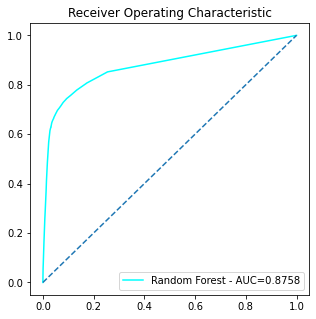

In [33]:
y_pred_proba = clf_rf.predict_proba(X_test)[::,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test,  y_pred_proba)
auc_rf = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_rf,tpr_rf,color="cyan",label="Random Forest - AUC=%.4f" % auc_rf)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.legend(loc=4)
plt.show()

### ---Logistic Regression---

In [34]:
# import the class
from sklearn.linear_model import LogisticRegression
# instantiate the model (using the default parameters)
clf_lr=LogisticRegression(solver='liblinear', random_state=0)
# fit the model with data
clf_lr.fit(X_train,y_train)
y_pred=clf_lr.predict(X_test)

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    135640
           1       0.58      0.06      0.12      5171

    accuracy                           0.96    140811
   macro avg       0.77      0.53      0.55    140811
weighted avg       0.95      0.96      0.95    140811



In [36]:
confusion_matrix(y_test, y_pred)

array([[135398,    242],
       [  4836,    335]], dtype=int64)

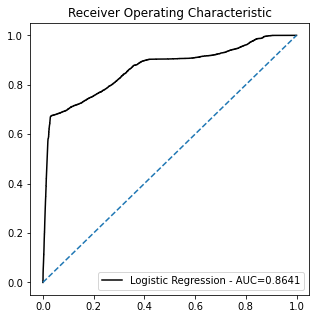

In [37]:
y_pred_proba = clf_lr.predict_proba(X_test)[::,1]
fpr_lr, tpr_lr, _ = roc_curve(y_test,  y_pred_proba)
auc_lr = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_lr,tpr_lr,color="black",label="Logistic Regression - AUC=%.4f" % auc_lr)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.legend(loc=4)
plt.show()

### ---LightGBM---

In [38]:
# build the lightgbm model
import lightgbm as lgb
clf_lgbm = lgb.LGBMClassifier()
clf_lgbm.fit(X_train, y_train)

# predict the results
y_pred=clf_lgbm.predict(X_test)

In [42]:
y_pred_train = clf_lgbm.predict(X_train)

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    135640
           1       0.56      0.61      0.58      5171

    accuracy                           0.97    140811
   macro avg       0.77      0.79      0.78    140811
weighted avg       0.97      0.97      0.97    140811



In [44]:
confusion_matrix(y_test, y_pred)

array([[133144,   2496],
       [  2032,   3139]], dtype=int64)

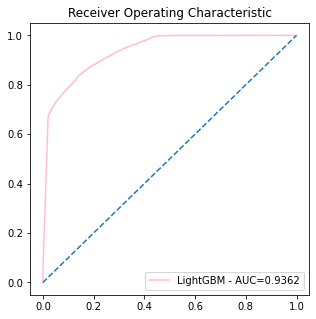

In [45]:
y_pred_proba = clf_lgbm.predict_proba(X_test)[::,1]
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test,  y_pred_proba)
auc_lgbm = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_lgbm,tpr_lgbm,color="pink",label="LightGBM - AUC=%.4f" % auc_lgbm)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.legend(loc=4)
plt.show()

### ROC Curve y AUC - Todos los modelos

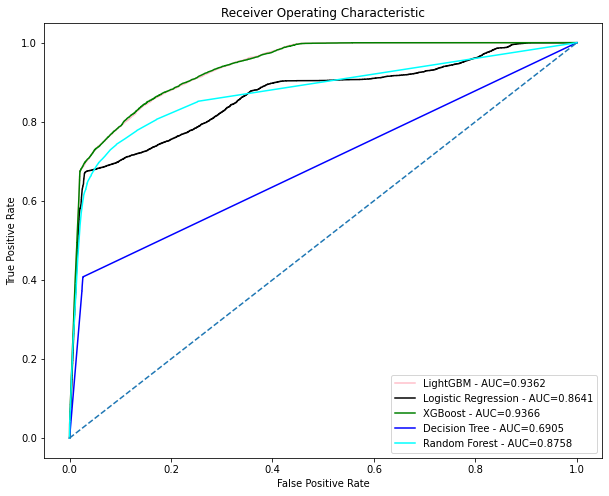

In [46]:
plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_lgbm,tpr_lgbm,color="pink",label="LightGBM - AUC=%.4f" % auc_lgbm)
plt.plot(fpr_lr,tpr_lr,color="black",label="Logistic Regression - AUC=%.4f" % auc_lr)
plt.plot(fpr_xgb,tpr_xgb,color="green",label="XGBoost - AUC=%.4f" % auc_xgb)
plt.plot(fpr_dt,tpr_dt,color="blue",label="Decision Tree - AUC=%.4f" % auc_dt)
plt.plot(fpr_rf,tpr_rf,color="cyan",label="Random Forest - AUC=%.4f" % auc_rf)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.legend(loc=4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig('ROC_Curve_Modelos.jpg')
plt.show()

### En base al rendimiento demostrado, se elige ---XGBoost--- como el algoritmo a desarrollar. 
También podría desarrolla LightGBM dado que tiene un rendimiento muy similar.

In [47]:
# comienzo nuevo proceso.

### Feature Engineering

In [48]:
# Anio Fecha Ultima Cobranza.
df['Fe_New1'] = pd.to_numeric(df['cob_fecuma'].astype(str).str.slice(0,4))

In [49]:
# Mes Fecha Ultima Cobranza.
df['Fe_New2'] = pd.to_numeric(df['cob_fecuma'].astype(str).str.slice(4,6))

In [50]:
# Anio Fecha Emisión de la Operación.
df['Fe_New3'] = pd.to_numeric(df['fecemi'].astype(str).str.slice(0,4))

In [51]:
# Mes Emisión de la Operación.
df['Fe_New4'] = pd.to_numeric(df['fecemi'].astype(str).str.slice(4,6))

In [52]:
# la diferencia entre el día de proceso y la última cobranza.
df['Fe_New5'] = (pd.Timestamp.now().normalize()-pd.to_datetime(df['cob_fecuma'], format='%Y%m%d')).dt.days

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469370 entries, 0 to 469369
Data columns (total 29 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   pol           469370 non-null  int64  
 1   endoso        469370 non-null  int64  
 2   item          469370 non-null  int64  
 3   fecemi        469370 non-null  int64  
 4   tipend        469370 non-null  object 
 5   idaseg        469370 non-null  int64  
 6   ase_antig_an  469370 non-null  int64  
 7   ase_cp        469370 non-null  int64  
 8   ase_codnac    469370 non-null  float64
 9   ase_nac       469370 non-null  object 
 10  idprod        469370 non-null  int64  
 11  pro_antig_an  469370 non-null  int64  
 12  tipveh        469370 non-null  int64  
 13  marca         469370 non-null  int64  
 14  modelo        469370 non-null  int64  
 15  anio          469370 non-null  int64  
 16  uso           469370 non-null  int64  
 17  uso_desc      469370 non-null  object 
 18  cobe

### Feature Selection

In [54]:
dfModel=df[['endoso', 'ase_antig_an', 'ase_cp', 'ase_codnac', 'idprod', 'pro_antig_an', 
            'marca', 'modelo', 'anio', 'uso', 'codcober', 'cob_ef', 
            'Fe_New1', 'Fe_New2', 'Fe_New3', 'Fe_New4', 'Fe_New5']]

In [55]:
# Es la variable dependiente/objetivo/target 'fraude'
dfTarget=df['fraude']

In [56]:
# Divido en training y testing. Utilizo 'stratify' para mantener la proporción de positivos y negativos en train y test.
X_train, X_test, y_train, y_test = train_test_split(dfModel, dfTarget, test_size = 0.3, random_state=45, stratify=dfTarget)

In [57]:
print("Training 0: %.0f" % (y_train.count()))
print("Training 1: %.0f" % (y_train.sum()))
print("            %.4f%%" % (y_train.sum() / y_train.count()))
print("")
print("Testing 0: %.0f" % (y_test.count()))
print("Testing 1: %.0f" % (y_test.sum()))
print("           %.4f%%" % (y_test.sum() / y_test.count()))

Training 0: 328559
Training 1: 12065
            0.0367%

Testing 0: 140811
Testing 1: 5171
           0.0367%


In [58]:
# !pip install xgboost
import xgboost as xgb
from xgboost import XGBClassifier ## Categorical target variable
# from xgboost import XGBRegressor ## Continuous target variable

In [59]:
def xgb_classifier(n_estimators, max_depth, reg_alpha, reg_lambda, min_child_weight, num_boost_round, gamma):
    params = {"booster": 'gbtree',
              "objective" : "binary:logistic",
              "eval_metric" : "auc", 
              "is_unbalance": True,
              "n_estimators": int(n_estimators),
              "max_depth" : int(max_depth),
              "reg_alpha" : reg_alpha,
              "reg_lambda" : reg_lambda,
              "gamma": gamma,
              "num_threads" : 20,
              "min_child_weight" : int(min_child_weight),
              "learning_rate" : 0.02,
              "subsample_freq" : 5,
              "seed" : 42,
              "verbosity" : 0,
              "num_boost_round": int(num_boost_round)}
    
    train_data = xgb.DMatrix(X_train, y_train, enable_categorical=True)
    
    cv_result = xgb.cv(params, train_data, 1000, early_stopping_rounds=100, stratified=True, nfold=3)
    return cv_result['test-auc-mean'].iloc[-1]

In [60]:
# !pip install bayesian-optimization
from bayes_opt import BayesianOptimization
xgbBO = BayesianOptimization(xgb_classifier, {  'n_estimators': (10, 100),
                                                'max_depth': (5, 40),
                                                'reg_alpha': (0.0, 0.1),
                                                'reg_lambda': (0.0, 0.1),
                                                'min_child_weight': (1, 10),
                                                'num_boost_round': (100, 1000),
                                                "gamma": (0, 10)
                                                })

In [61]:
xgbBO.maximize(n_iter=50, init_points=2)

|   iter    |  target   |   gamma   | max_depth | min_ch... | n_esti... | num_bo... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.947    |  6.821    |  17.0     |  5.64     |  95.73    |  579.5    |  0.08517  |  0.03408  |
|  2        |  0.9392   |  1.463    |  35.14    |  1.612    |  65.01    |  419.6    |  0.03243  |  0.07853  |
|  3        |  0.9469   |  7.824    |  17.36    |  4.746    |  92.56    |  584.4    |  0.06005  |  0.06211  |
|  4        |  0.945    |  0.5185   |  13.74    |  9.679    |  99.23    |  767.6    |  0.05606  |  0.0285   |
|  5        |  0.9468   |  6.458    |  33.94    |  3.815    |  98.72    |  966.3    |  0.06292  |  0.04389  |
|  6        |  0.9411   |  0.4882   |  25.98    |  5.957    |  10.93    |  905.7    |  0.07265  |  0.035    |
|  7        |  0.9425   |  0.961    |  32.11    |  8.416    |  11.94    |  672.2    |  0.03265  |  0.004492 |
|  8      

|  45       |  0.9461   |  5.437    |  38.89    |  1.788    |  11.85    |  350.1    |  0.03491  |  0.07007  |
|  46       |  0.9464   |  5.169    |  39.52    |  2.896    |  46.31    |  323.8    |  0.07343  |  0.03025  |
|  47       |  0.9468   |  8.351    |  38.91    |  1.42     |  33.87    |  751.2    |  0.09759  |  0.03369  |
|  48       |  0.9457   |  2.88     |  39.36    |  3.345    |  16.76    |  777.8    |  0.05812  |  0.03231  |
|  49       |  0.9469   |  7.712    |  39.4     |  7.865    |  62.8     |  732.5    |  0.02775  |  0.01911  |
|  50       |  0.9465   |  0.5218   |  8.416    |  3.174    |  50.13    |  749.6    |  0.05705  |  0.04041  |
|  51       |  0.9473   |  4.553    |  10.4     |  2.353    |  69.28    |  713.1    |  0.048    |  0.09373  |
|  52       |  0.9469   |  5.718    |  32.62    |  8.979    |  94.23    |  706.2    |  0.03165  |  0.04221  |


In [63]:
xgbBO.max

{'target': 0.9472929999999998,
 'params': {'gamma': 6.081126098947912,
  'max_depth': 11.21627408761934,
  'min_child_weight': 3.7100170137477195,
  'n_estimators': 98.33745680001817,
  'num_boost_round': 879.2612913813967,
  'reg_alpha': 0.07314087105844085,
  'reg_lambda': 0.02258529645486931}}

In [64]:
# clf_xgb=XGBClassifier(use_label_encoder=False, 
#                      colsample_bytree = 0.5, 
#                      learning_rate = 0.2,
#                      gamma =  7.913757545198536,
#                      max_depth = 7,
#                      min_child_weight = 1.9202611553414282,
#                      alpha = 10, 
#                      n_estimators = 45,
#                      reg_alpha =   0.07711402098002348,
#                      reg_lambda = 0.0433274269286166,
#                      eval_metric='auc')

clf_xgb=XGBClassifier(use_label_encoder=False, 
                     colsample_bytree = 0.5, 
                     learning_rate = 0.2,
                     gamma =  6.081126098947912,
                     max_depth = 11,
                     min_child_weight = 3.7100170137477195,
                     alpha = 10, 
                     n_estimators = 98,
                     reg_alpha =  0.07314087105844085,
                     reg_lambda = 0.02258529645486931,
                     eval_metric='auc')

In [65]:
# Fitting model
clf_xgb.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='auc',
              gamma=6.081126098947912, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=11, min_child_weight=3.7100170137477195, missing=nan,
              monotone_constraints='()', n_estimators=98, n_jobs=4,
              num_parallel_tree=1, random_state=0,
              reg_alpha=0.07314087105844085, reg_lambda=0.02258529645486931,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

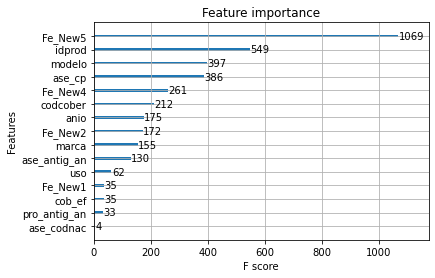

In [66]:
# la variable que mas toma en cuenta el clasificador.
xgb.plot_importance(clf_xgb, ax=plt.gca())
y_pred  = clf_xgb.predict(X_test)

In [67]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    135640
           1       0.98      0.65      0.78      5171

    accuracy                           0.99    140811
   macro avg       0.98      0.83      0.89    140811
weighted avg       0.99      0.99      0.99    140811



In [68]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[135558,     82],
       [  1785,   3386]], dtype=int64)

### ROC Curve y AUC modelo antes y después de Feature Engineering

The ROC curve shows the trade-off between sensitivity (or TPR) and specificity (1 – FPR). Classifiers that give curves closer to the top-left corner indicate a better performance. As a baseline, a random classifier is expected to give points lying along the diagonal (FPR = TPR). The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

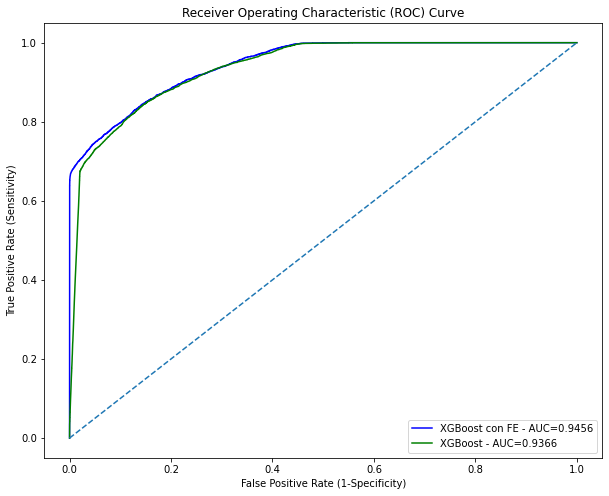

In [69]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

y_pred_proba = clf_xgb.predict_proba(X_test)[::,1]
fpr_xgb_Fe, tpr_xgb_Fe, _ = roc_curve(y_test,  y_pred_proba)
auc_xgb_Fe = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(fpr_xgb_Fe,tpr_xgb_Fe,color="blue",label="XGBoost con FE - AUC=%.4f" % auc_xgb_Fe)
plt.plot(fpr_xgb,tpr_xgb,color="green",label="XGBoost - AUC=%.4f" % auc_xgb)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.legend(loc=4)
plt.xlabel("False Positive Rate (1-Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.savefig('ROC_Curve_Final.jpg')
plt.show()